# Useful Functions in Bifrost

<a href="https://colab.research.google.com/github/ledatelescope/bifrost/blob/master/tutorial/01_useful_functions.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>

With the basics of how to get data onto and off of the GPU, we can now start to look at useful functions in Bifrost.  Bifrost provides many functions that run on GPUs and interact via `bifrost.ndarray`s:

 * `bifrost.fdmt` — the fast dispersion measure transform
 * `bifrost.fft` — multi-dimensional Fourier transforms
 * `bifrost.fir` — finite impulse response (FIR) filters
 * `bifrost.linalg` — linear algebra module for matrix-matrix operations
 * `bifrost.map` — JIT functions for element-wise operations
 * `bifrost.quantize` — quantizers for moving between floating and integer types
 * `bifrost.reduce` — reduction (sum, min, max, etc.) array operations
 * `bifrost.romein` — data gridder
 * `bifrost.transpose` — data transpositions
 * `bifrost.unpack` — unpackers for moving between integer and floating types

We have already seen maps and FFTs in action so let's look at some of the other functions here.

In [1]:
%%capture install_log
# Import bifrost, but attempt to auto-install if needed (and we're running on
# Colab). If something goes wrong, evaluate install_log.show() in a new block
# to retrieve the details.
try:
  import bifrost
except ModuleNotFoundError:
  try:
    import google.colab
    !sudo apt-get -qq install exuberant-ctags libopenblas-dev software-properties-common build-essential
    !pip install -q contextlib2 pint simplejson scipy git+https://github.com/ctypesgen/ctypesgen.git
    ![ -d ~/bifrost/.git ] || git clone https://github.com/ledatelescope/bifrost ~/bifrost
    !(cd ~/bifrost && ./configure && make -j all && sudo make install)
    import bifrost
  except ModuleNotFoundError:
    print("Sorry, could not import bifrost and we're not on colab.")

## bifrost.reduce

`bifrost.reduce` is a complement to `bifrost.map` that deals with operations that reduce the size of an array, like a summation along an axis.

In [2]:
import numpy
data = numpy.random.randn(10, 1000)
data = data.astype(numpy.float32)
sdata = data.sum(axis=1)
print('numpy:', sdata)

data = bifrost.ndarray(data, space='cuda')
sdata = bifrost.ndarray(shape=(data.shape[0], 1), dtype=sdata.dtype,
                        space='cuda')
bifrost.reduce(data, sdata, op='sum')
sdata2 = sdata.copy(space='system')
print('bifrost:', sdata2[:,0])

numpy: [  4.140649   18.068268  -28.093277   -3.199566   -7.7478523  32.780075
 -37.850746  -24.040245   25.390383   54.569324 ]
bifrost: [  4.140649   18.068268  -28.093285   -3.1995583  -7.7478404  32.780083
 -37.850758  -24.040249   25.390385   54.56932  ]


During a reduction Bifrost uses the difference in the dimensions of the input and output arrays to determine what axis to run the reduction on.  Here we have summed along the second axis by setting that dimension to one for sdata.

In addition to sum, there are also reduction operations that work on power, i.e., magnitude squared:

In [3]:
data = numpy.random.randn(10, 1000)
data = data.astype(numpy.float32)
sdata = (data**2).sum(axis=1)
print('numpy:', sdata)

data = bifrost.ndarray(data, space='cuda')
sdata = bifrost.ndarray(shape=(data.shape[0], 1), dtype=sdata.dtype,
                        space='cuda')
bifrost.reduce(data, sdata, op='pwrsum')
sdata2 = sdata.copy(space='system')
print('bifrost:', sdata2[:,0])

numpy: [1010.9479  1074.0662   997.83887  917.8666   988.5895   993.8688
 1045.6895   993.13806 1067.0187  1014.4079 ]
bifrost: [1010.94824 1074.0671   997.8386   917.8666   988.58954  993.8687
 1045.6901   993.1382  1067.019   1014.4079 ]


`bifrost.reduce` currently only supports explicit reduction along one axis at a time.  However, it may be possible to run multi-dimensional reductions for reshaping the data:

In [4]:
data = numpy.random.randn(10, 1000)
data = data.astype(numpy.float32)
sdata = (data**2).sum()
print('numpy:', sdata)

data = bifrost.ndarray(data, space='cuda')
data = data.reshape(data.shape[0]*data.shape[1])
sdata = bifrost.ndarray(shape=(1,), dtype=sdata.dtype, space='cuda')
bifrost.reduce(data, sdata, op='pwrsum')
sdata2 = sdata.copy(space='system')
print('bifrost:', sdata2[0])

numpy: 10091.392
bifrost: 10091.382


## bifrost.transpose

For some data processing it may be more convenient to have the axis in a different order.  To transpose a GPU array in Bifrost there is the `bifrost.transpose` function:

In [5]:
data = numpy.random.randn(10, 1000)
data = data.astype(numpy.float32)
tdata = data.T.copy()
print('numpy:', data[0,9], '->', tdata[9,0])

data = bifrost.ndarray(data, space='cuda')
tdata = bifrost.ndarray(shape=data.shape[::-1], dtype=data.dtype,
                        space='cuda')
bifrost.transpose(tdata, data, axes=(1,0))
data2 = data.copy(space='system')
tdata2 = tdata.copy(space='system')
print('bifrost:', data2[0,9], '->', tdata2[9,0])

numpy: -0.3481426 -> -0.3481426
bifrost: -0.3481426 -> -0.3481426


Unlike `bifrost.reduce`, `bifrost.transpose` requires you to have both an output array with the correct shape and to explicitly specify the axis ordering in the call.

This function also supports general data re-ordering operations as well:

In [6]:
data = numpy.random.randn(10, 20, 30, 40)
data = data.astype(numpy.float32)
tdata = data.transpose(1,3,2,0).copy()
print('numpy:', data[1,3,5,7], '->', tdata[3,7,5,1])

data = bifrost.ndarray(data, space='cuda')
tdata = bifrost.ndarray(shape=[data.shape[v] for v in (1,3,2,0)],
                        dtype=data.dtype, space='cuda')
bifrost.transpose(tdata, data, axes=(1,3,2,0))
data2 = data.copy(space='system')
tdata2 = tdata.copy(space='system')
print('bifrost:', data2[1,3,5,7], '->', tdata2[3,7,5,1])

numpy: -0.78903913 -> -0.78903913
bifrost: -0.78903913 -> -0.78903913


## bifrost.fdmt

Bifrost includes a module for computing the fast dispersion measure transform of [Zackay and Ofek](https://iopscience.iop.org/article/10.3847/1538-4357/835/1/11/meta) (2017, ApJ 835 11) for incoherent dedispersion.  Like the `bifrost.fft` module using the FDMT requires some setup.  To get started let's make a simulation dispersed pulse at a DM of 5.5 pc/cm³:

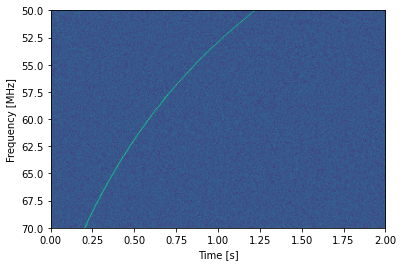

In [11]:
DM = 1.25
time = numpy.linspace(0, 2, 1000)
freq = numpy.linspace(50e6, 70e6, 200)
data = numpy.random.randn(freq.size, time.size)
data[:,100] += 10.0
data[:,101] += 8.0
data[:,102] += 4.0
data[:,103] += 1.0
for i in range(freq.size):
    delay = 4.15e-3 * DM * ((freq[i]/1e9)**-2 - (freq[-1]/1e9)**-2)
    delay = int(round(delay / (time[1] - time[0])))
    data[i,:] = numpy.roll(data[i,:], delay)
data = data.astype(numpy.float32)

import pylab
pylab.imshow(data, extent=(time[0], time[-1], freq[-1]/1e6, freq[0]/1e6))
pylab.axis('auto')
pylab.xlabel('Time [s]')
pylab.ylabel('Frequency [MHz]'); None

Now setup and run the FDMT on the data:

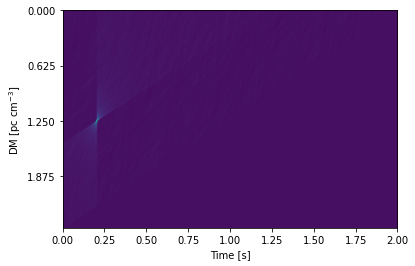

In [17]:
data = bifrost.ndarray(data, space='cuda')
ddata = bifrost.ndarray(shape=(time.size, time.size),
                        dtype=data.dtype, space='cuda')
f = bifrost.fdmt.Fdmt()
f.init(freq.size, time.size, freq[0]/1e6, (freq[1]-freq[0])/1e6)
f.execute(data, ddata)
ddata2 = ddata.copy(space='system')

tint = time[1] - time[0]
dm = numpy.arange(time.size)*1.0
dm *= tint / 4.15e-3 / ((freq[0]/1e9)**-2 - (freq[-1]/1e9)**-2)

pylab.imshow(ddata2, extent=(time[0], time[-1], dm[-1], dm[0]))
pylab.axis('auto')
pylab.xlabel('Time [s]')
pylab.ylabel('DM [pc cm$^{-3}$]')
pylab.yticks(numpy.arange(0.0, 2.5, 0.625)); None

## bifrost.linalg.LinAlg

The final useful function in Bifrost that we will explore is `bifrost.linalg.LinAlg`.  This function implements a variety of matrix-matrix operations.  It supports:

 * $C = \alpha A × B + \beta C$
 * $C = \alpha A × A^H + \beta C$ (if $B$ is not provided)
 * $C = \alpha B^H × B + \beta C$ (if $A$ is not provided)

where $\alpha$ and $\beta$ are scalar values, $×$ is a matrix product, and $·^{H}$ denotes a Hermetian transpose.  For matricies with more than two dimensions the semantics are the same as for `numpy.matmul`:  The last two dims represent the matrix, and all other dimensions are used as batch dimensions to be matched or broadcast between $A$ and $B$.

These three operations make this function useful for implementing simple beamformers or cross-correlation operations.  For a beamformer:

In [18]:
data = numpy.random.randn(1000, 32, 48)   # time, channel, input
data = data.astype(numpy.float32)         # beam, channel input
coeffs = numpy.ones((1, 32, 48))
for i in range(coeffs.shape[1]):
    coeffs[:,i] = i/32.0
coeffs = coeffs.astype(numpy.float32)
beam = numpy.matmul(coeffs.transpose(1,0,2), data.transpose(1,2,0))
beam = beam.transpose(2,0,1)               # time, channel, beam
print('numpy.matmul:', beam[0,10,0])
print('numpy manual:', (data[0,10,:]*coeffs[0,10,:]).sum())

data = bifrost.ndarray(data, space='cuda')
coeffs = bifrost.ndarray(coeffs, space='cuda')
beam = bifrost.ndarray(shape=(32,1,1000), dtype=numpy.float32,
                       space='cuda')
l = bifrost.linalg.LinAlg()
beam = l.matmul(1.0, coeffs.transpose(1,0,2), data.transpose(1,2,0),
                0.0, beam)
beam2 = beam.copy(space='system')
beam2 = beam2.transpose(2, 0, 1)
print('bifrost:', beam2[0,10,0])

numpy.matmul: -0.06674242
numpy manual: -0.06674248
bifrost: -0.06674242


This example illustrates one of the complexities when dealing with real data.  The axis order that makes the most sense for some operations may not be the best match for other operations.  Luckily `bifrost.linalg.LinAlg` supports at least some on-the-fly transpose operations and an explict transpose may not be necessary.

## Remaining Functions

The remaining functions of `bifrost.fir`, `bifrost.romein`, `bifrost.quantize`, and `bifrost.unpack` will not be addressed here.  However, `bifrost.quantize` and `bifrost.unpack` will be used later in the tutorial.